# Imports & initialization

In [21]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
import pickle
import quandl
from sklearn.model_selection import train_test_split,TimeSeriesSplit,GridSearchCV
from sklearn.preprocessing import StandardScaler

In [22]:
quandl.ApiConfig.api_key = "1fvGunr_VZuoZCNgnQkg"
START = '2000-01-01'
END = '2021-05-30'
np.random.seed(seed=1)

# Data

In [23]:
# Daily data from Quandl
# Arbitrarily added data from same databases
quandl_dict = {
	# Futures
	'gold': "CHRIS/CME_GC1.4", #Gold Futures, Continuous Contract #1 (GC1) (Front Month)
	'eurodollar': "CHRIS/CME_ED1.4", #Eurodollar Futures, Continuous Contract #1 (ED1) (Front Month)
	'silver': "CHRIS/CME_SI1.4", #Silver Futures, Continuous Contract #1 (SI1) (Front Month)
	'DCOILWTICO': 'FRED/DCOILWTICO', #Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma
	'MplsHRWI': 'CHRIS/MGEX_MW5.4', # Minneapolis Hard Red Spring Wheat Futures, Continuous Contract #5 (MW5)
	'BAB90D': 'CHRIS/ASX_IR1', # 90 Day Bank Accepted Bills Futures, Continuous Contract #1 (IR1) (Front Month)
	# Major currency pair spot rates
	'USDCAD': "FED/RXI_N_B_CA", #CANADA -- SPOT EXCHANGE RATE, CANADIAN $/US$, Business day
	'EURUSD': "FED/RXI_US_N_B_EU", #SPOT EXCHANGE RATE - EURO AREA, Business day
	'GBPUSD': "FED/RXI_US_N_B_UK", #UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK), Business day
	'USDJPY': "FED/RXI_N_B_JA", #JAPAN -- SPOT EXCHANGE RATE, YEN/US$, Business day
	'AUDUSD': "FED/RXI_US_N_B_AL", #AUSTRALIA -- SPOT EXCHANGE RATE US$/AU$ (RECIPROCAL OF RXI_N.B.AL), Business day
	'NZDUSD': "FED/RXI_US_N_B_NZ", #NEW ZEALAND -- SPOT EXCHANGE RATE, US$/NZ$ RECIPROCAL OF RXI_N.B.NZ, Business day
	'USDCHF': "FED/RXI_N_B_SZ", #SWITZERLAND -- SPOT EXCHANGE RATE, FRANCS/US$, Business day
	'USDNOK': "FED/RXI_N_B_NO", #NORWAY -- SPOT EXCHANGE RATE, KRONER/US$, Business day
	'USDCNY': "FED/RXI_N_B_CH", #CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R., Business day
	'USDINR': "FED/RXI_N_B_IN", #INDIA -- SPOT EXCHANGE RATE, RUPEES/US$, Business day
	'USDVEB': 'FED/RXI_N_B_VE',	# VENEZUELA -- SPOT EXCHANGE RATE, BOLIVARES/US$, Business day
	'USDTWD': 'FED/RXI_N_B_TA', # TAIWAN -- SPOT EXCHANGE RATE, NT$/US$, Business day
	'USDTHB': 'FED/RXI_N_B_TH', # THAILAND -- SPOT EXCHANGE RATE, BAHT/US$, Business day
	'USDSLR': 'FED/RXI_N_B_SL', # SRI LANKA -- SPOT EXCHANGE RATE, RUPEES/US$, Business day
	'USDKRW': 'FED/RXI_N_B_KO', # KOREA -- SPOT EXCHANGE RATE, WON/US$, Business day
	'USDSEK': 'FED/RXI_N_B_SD', # SWEDEN -- SPOT EXCHANGE RATE, KRONOR/US$, Business day
	'USDSGD': 'FED/RXI_N_B_SI', # SINGAPORE -- SPOT EXCHANGE RATE, SINGAPORE $/US$, Business day
	'USDHKD': 'FED/RXI_N_B_HK', # HONG KONG -- SPOT EXCHANGE RATE, HK$/US$, Business day
	'USDMXP': 'FED/RXI_N_B_MX',	# MEXICO -- SPOT EXCHANGE RATE, PESOS/US$, Business day
	'USDMYR':'FED/RXI_N_B_MA',	# MALAYSIA -- SPOT EXCHANGE RATE, RINGGIT/US$, Business day
	'DTWEXM': "FRED/DTWEXM", # Trade Weighted U.S. Dollar Index: Major Currencies
	'DTWEXB': "FRED/DTWEXB", # Trade Weighted U.S. Dollar Index: Broad
	# Interest rates
	'DFF': "FRED/DFF", #Effective Federal Funds Rate
	'DTB3': "FRED/DTB3", #3-Month Treasury Bill: Secondary Market Rate
	'DGS5': "FRED/DGS5", #5-Year Treasury Constant Maturity Rate
	'DGS10': "FRED/DGS10",#10-Year Treasury Constant Maturity Rate
	'DGS30': "FRED/DGS30", #30-Year Treasury Constant Maturity Rate
	'T5YIE': "FRED/T5YIE", #5-year Breakeven Inflation Rate
	'T10YIE': "FRED/T10YIE", #10-year Breakeven Inflation Rate
	'T5YIFR': "FRED/T5YIFR",#5-Year, 5-Year Forward Inflation Expectation Rate 
	'TEDRATE': "FRED/TEDRATE", #TED Spread
	'DPRIME': "FRED/DPRIME" #Bank Prime Loan Rate
}

# Econ features that are not daily (weekly, monthly & quarterly data - need to ffill)
sparse_econ_data = {
	# Growth
	'GDP' :"FRED/GDPPOT", #Gross Domestic Product
	'GDPC1': "FRED/GDPC1", #Real Gross Domestic Product
	'GDPPOT': "FRED/GDPC1", #Real Potential Gross Domestic Product
	# Prices and Inflation
	'CPIAUCSL': "FRED/CPIAUCSL", #Consumer Price Index for All Urban Consumers: All Items
	'CPILFESL': "FRED/CPILFESL", #Consumer Price Index for All Urban Consumers: All Items Less Food & Energy
	'GDPDEF': "FRED/GDPDEF", #Gross Domestic Product: Implicit Price Deflator
	# Money Supply
	'BASE': "FRED/BASE", #St. Louis Adjusted Monetary Base
	'M1': "FRED/M1", #M1 Money Stock
	'M2': "FRED/M2", #M2 Money Stock
	'M1V': "FRED/M1V", #Velocity of M1 Money Stock
	'M2V': "FRED/M2V", #Velocity of M2 Money Stock
	# Employment
	'UNRATE': "FRED/UNRATE", #Civilian Unemployment Rate
	'NROU': "FRED/NROU", #Natural Rate of Unemployment (Long-Term)
	'NROUST': "FRED/NROUST", #Natural Rate of Unemployment (Short-Term)
	'CIVPART': "FRED/CIVPART", #Civilian Labor Force Participation Rate
	'EMRATIO': "FRED/EMRATIO", #Civilian Employment-Population Ratio
	'UNEMPLOY': "FRED/UNEMPLOY", #Unemployed level
	'PAYEMS': "FRED/PAYEMS", #All Employees: Total nonfarm
	'MANEMP': "FRED/MANEMP", #All Employees: Manufacturing
	'ICSA': "FRED/ICSA", #Initial Claims
	# Income and Expenditure
	'MEHOINUSA672N': "FRED/MEHOINUSA672N", #Real Median Household Income in the United States
	'DSPIC96': "FRED/DSPIC96", #Real Disposable Personal Income
	'PCE': "FRED/PCE", #Personal Consumption Expenditures
	'PCEDG': "FRED/PCEDG", #Personal Consumption Expenditures: Durable Goods
	'PSAVERT': "FRED/PSAVERT", #Personal Saving Rate
	'RRSFS': "FRED/RRSFS", #Real Retail and Food Services Sales
	'DSPI': "FRED/DSPI", #Disposable personal income
	# Debt
	'GFDEBTN': "FRED/GFDEBTN", #Federal Debt: Total Public Debt
	'GFDEGDQ188S': "FRED/GFDEGDQ188S", #Federal Debt: Total Public Debt as Percent of Gross Domestic Product
	'EXCSRESNW': "FRED/EXCSRESNW", #Excess Reserves of Depository Institutions
	'TOTCI': "FRED/TOTCI", #Commercial and Industrial Loans, All Commercial Banks
	# Other Economic Indicators
	'INDPRO': "FRED/INDPRO", #Industrial Production Index
	'TCU': "FRED/TCU", #Capacity Utilization: Total Industry
	'HOUST': "FRED/HOUST", #Housing Starts: Total: New Privately Owned Housing Units Started
	'GPDI': "FRED/GPDI", #Gross Private Domestic Investment
	'CP': "FRED/CP", #Corporate Profits After Tax (without IVA and CCAdj)
	'STLFSI': "FRED/STLFSI", #St. Louis Fed Financial Stress Index
	'USSLIND': "FRED/USSLIND", #Leading Index for the United States
	'S&P 500 Dividend Yield by Month': "MULTPL/SP500_DIV_MONTH",#12-month real dividend per share inflation adjusted February, 2020 dollars. Data courtesy Standard & Poor's and Robert Shiller.
	'S&P 500 Earnings by Month':"MULTPL/SP500_EARNINGS_MONTH",#S&P 500 Earnings Per Share. 12-month real earnings per share inflation adjusted, constant February, 2020 dollars. Sources: Standard & Poor's for current S&P 500 Earnings. Robert Shiller and his book Irrational Exuberance for historic S&P 500 Earnings.
	'S&P 500 Earnings Yield by Month':"MULTPL/SP500_EARNINGS_YIELD_MONTH",#S&P 500 Earnings Yield. Earnings Yield = trailing 12 month earnings divided by index price (or inverse PE) Yields following September, 2019 (including current yield) are estimated based on 12 month earnings through September, 2019 the latest reported by S&P. Source: Standard & Poor's
	'S&P 500 PE Ratio by Month':"MULTPL/SP500_PE_RATIO_MONTH",#Price to earnings ratio, based on trailing twelve month as reported earnings. Current PE is estimated from latest reported earnings and current market price. Source: Robert Shiller and his book Irrational Exuberance for historic S&P 500 PE Ratio.
}

trust_funds = ['VIX','XLE','XLU','XLI','XLK','XLV','XLY','XLP','XLB']

# Construct Target Variable

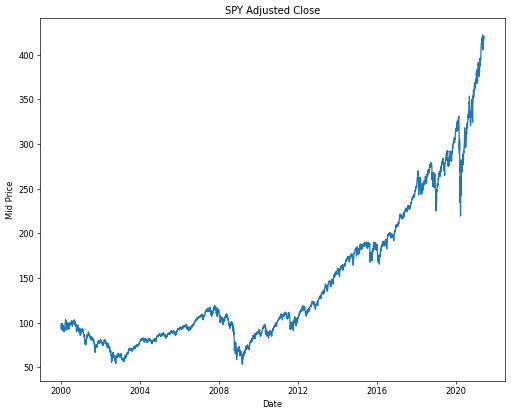

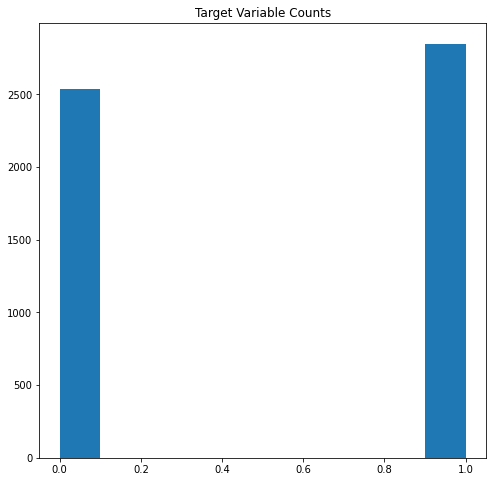

In [24]:
# We want to predict whether the market goes up or down from day to day
# so we need our model to know which days had a positive percent change

df = web.DataReader('SPY', 'yahoo', START, END)

## Visualize entire market since 2000
plt.figure(figsize=(10, 8), dpi=60)
plt.title("SPY Adjusted Close")
plt.plot(df['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Mid Price')
# plt.show()

# Find percent change between each day
# Shift -1 for next day's return
df['SPY_forward_ret'] = df['Close'].shift(-1)/df['Open'].shift(-1) - 1

# If tomorrow's return > 0, then 1
# If tomorrow's return <= 0, then 0
df['profit'] = 0
df.loc[df['SPY_forward_ret'] > 0.0, 'profit'] = 1

# Remove look ahead bias
del df['SPY_forward_ret']

# Distribution of y
plt.figure(figsize=(8,8))
plt.hist('profit', data=df)
plt.title('Target Variable Counts')
plt.show()

# Build Helper Functions

In [25]:
# Access large economic indicators from quandl
def get_quandl_data(df, quandl_dict, start, end):
	data = quandl.get(list(quandl_dict.values()), start_date=start, end_date=end)
	data.columns = list(quandl_dict.keys())
	df = pd.concat([df, data.reindex(df.index)], axis=1)
	return df

# Access trust fund data from yahoo finance
def get_trust_funds(df, trust_funds, start, end):
	for fund in trust_funds:
		df_temp = web.DataReader(fund, 'yahoo', start, end)
		df_temp = df_temp['Adj Close'].to_frame()
		df_temp.columns = ['{}_adj_cl'.format(fund)]
		df = pd.concat([df, df_temp.reindex(df.index)], axis=1)
	return df

# Function to get sparse econ data (frequency != daily) from Quandl.
# Also compute the change in economic data.
# All econ data are preproccessed using ffill.
def get_sparse_econ_data(df, econ_dict, start,end):
	# Get raw econ data
	data = quandl.get(list(econ_dict.values()), start_date=start, end_date=end)
	data.columns = list(econ_dict.keys())
	# Get econ data, transformed using percentage return
	ret_data = quandl.get(list(econ_dict.values()), start_date=start, end_date=end, transform="rdiff")
	ret_data.columns = [col + '_ret' for col in list(econ_dict.keys())]

	data = data.ffill()
	data = data.reindex(df.index)
	data = data.ffill()

	ret_data = ret_data.ffill()
	ret_data = ret_data.reindex(df.index)
	ret_data = ret_data.ffill()

	df = pd.concat([df,data, ret_data], axis=1)
	return df

# Compute additional derived features
# iterate through each existing feature and compute key statistics (rolling) for multiple lookback periods.
def derive_features(df):
	features = df.columns
	# Iterate through each column in df
	for col in features:
		if col != 'profit':
			# Daily change
			df[col+'_ret'] = df[col].pct_change()
			df[col+'_diff'] = df[col].diff()
			# Lookback periods
			lookback = [5,21, 63, 126, 252] # 1 week, 1 month, 1 quarter, half year, 1 year
			
			# Compute key statistics for each lookback period
			for i in lookback:
				df[col+'_ret_' + str(i)] = df[col]/df[col].shift(i) - 1
				#Return-based
				df[col+'_rolling_mean_' + str(i)] = df[col+'_ret'].rolling(i).mean()
				df[col+'_rolling_median_' + str(i)] = df[col+'_ret'].rolling(i).median()
				df[col+'_rolling_stdev_' + str(i)] = df[col+'_ret'].rolling(i).std()
				df[col+ '_rolling_skew_' + str(i)] = df[col+'_ret'].rolling(i).skew()
				df[col+ '_rolling_kurt_' + str(i)] = df[col+'_ret'].rolling(i).kurt()
				df[col+ '_rolling_min_' + str(i)] = df[col+'_ret'].rolling(i).min()
				df[col+ '_rolling_max_' + str(i)] = df[col+'_ret'].rolling(i).max()
				df[col+ '_rolling_corr_' + str(i)] = df[col+'_ret'].rolling(i).corr()
				df[col+ '_ewma_' + str(i)] = pd.DataFrame.ewm(df[col], span= i).mean()
				# Relative level
				df[col+'_rel_lvl_mean_' + str(i)] = df[col]/df[col].rolling(i).mean()
				df[col+'_rel_lvl_min_' + str(i)] = df[col]/df[col].rolling(i).min()
				df[col+'_rel_lvl_max_' + str(i)] = df[col]/df[col].rolling(i).max()                        
	return df

In [19]:
# Import daily frequency data
df = get_quandl_data(df,quandl_dict,START,END)
df = get_trust_funds(df, trust_funds, START, END)
# Compute additional derived features
df = derive_features(df) 

# Import economic data from Quandl
# Due to low frequency of sparse_econ_data, not included when calling derived features
df = get_sparse_econ_data(df,sparse_econ_data, START, END)
df.to_csv('data_before.csv')

ValueError: Wrong number of items passed 2, placement implies 1

# Data Preprocessing

In [ ]:
df.tz_localize('US/Pacific')

# Get list of columns that have more nans than the threshold percentage
def rmissingvaluecol(df,threshold):
	l = list(df.drop(df.loc[:,list(((df.isnull().sum()/len(df.index))>=threshold))].columns, 1).columns.values)
	print("Columns having more than 1 percent missing values:" ,(df.shape[1] - len(l))) # df.shape[1] is col count
	return l

df = df.replace([np.inf, -np.inf], np.nan)
cols = rmissingvaluecol(df, .01)
df = df[cols]
df.dropna(inplace=True)
df.to_csv('data_after.csv')

# Train/test split

In [10]:
# Split data set
X = df.loc[:, df.columns != 'profit']
y = df.loc[:, df.columns == 'profit']

# Test set uses 20% of the data, no shuffle since we're dealing with time series
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

# Summary
print("Train/Test Split Results:")
print("X Train Set:")
print(X_train_raw.shape)
print("X Test Set:")
print(X_test_raw.shape)

Train/Test Split Results:
X Train Set:
(4125, 1220)
X Test Set:
(1032, 1220)


# Standardization

In [11]:
# Initialize and fit scaler
scaler = StandardScaler()
# Fit scaler using the training data
scaler.fit(X_train_raw)

# Transform the raw data
X_train_standardized = scaler.transform(X_train_raw)
X_test_standardized = scaler.transform(X_test_raw)